In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

import os

from skopt import forest_minimize
from lightfm import LightFM, evaluation
from sklearn.feature_extraction import DictVectorizer

/Users/chandan/personal/lightfm/lightfm/_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [2]:
%matplotlib inline

In [62]:
DATA_PATH = "/Users/chandan/personal/capillary-hackathon/dataset"
SUB_PATH = "/Users/chandan/personal/capillary-hackathon/prediction"

In [4]:
train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))

In [30]:
test = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

In [5]:
product_attributes = pd.read_csv(os.path.join(DATA_PATH, "product_attributes.csv"))

In [6]:
train["OrderDate"] = pd.to_datetime(train["OrderDate"], format="%d/%m/%y")

In [7]:
train.dtypes

UserId                int64
productid             int64
Quantity              int64
OrderDate    datetime64[ns]
dtype: object

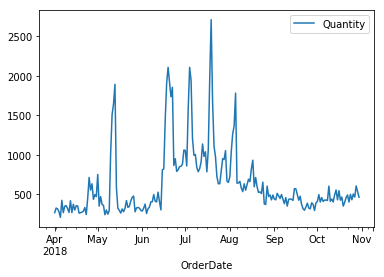

In [8]:
train.groupby("OrderDate").agg({"Quantity":sum}).plot()

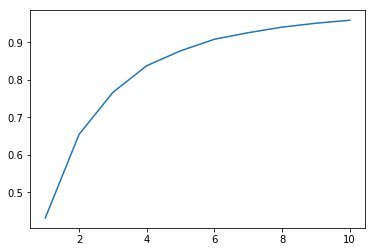

In [9]:
train.groupby("UserId").size().value_counts(normalize=True).cumsum().head(10).plot()

In [10]:
train.describe() 

,UserId,productid,Quantity
count,132551.000000,1.325510e+05,132551.000000
mean,18112.261220,1.235589e+07,1.013670
std,8941.055696,5.491942e+05,0.152367
min,0.000000,1.113919e+07,1.000000
25%,10283.000000,1.166012e+07,1.000000
50%,20746.000000,1.240766e+07,1.000000
75%,26784.000000,1.265836e+07,1.000000
max,27777.000000,1.412948e+07,12.000000


In [11]:
print(train["UserId"].unique().shape, train["productid"].unique().shape)

(27778,) (3026,)


In [12]:
def get_df_matrix_mappings(df, row_name, col_name):
    """Map entities in interactions df to row and column indices
    Parameters
    ----------
    df : DataFrame
        Interactions DataFrame.
    row_name : str
        Name of column in df which contains row entities.
    col_name : str
        Name of column in df which contains column entities.
    Returns
    -------
    rid_to_idx : dict
        Maps row ID's to the row index in the eventual interactions matrix.
    idx_to_rid : dict
        Reverse of rid_to_idx. Maps row index to row ID.
    cid_to_idx : dict
        Same as rid_to_idx but for column ID's
    idx_to_cid : dict
    """


    # Create mappings
    rid_to_idx = {}
    idx_to_rid = {}
    for (idx, rid) in enumerate(df[row_name].unique().tolist()):
        rid_to_idx[rid] = idx
        idx_to_rid[idx] = rid

    cid_to_idx = {}
    idx_to_cid = {}
    for (idx, cid) in enumerate(df[col_name].unique().tolist()):
        cid_to_idx[cid] = idx
        idx_to_cid[idx] = cid

    return rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid

In [13]:
def df_to_matrix(df, row_name, col_name):
    """Take interactions dataframe and convert to a sparse matrix
    Parameters
    ----------
    df : DataFrame
    row_name : str
    col_name : str
    Returns
    -------
    interactions : sparse csr matrix
    rid_to_idx : dict
    idx_to_rid : dict
    cid_to_idx : dict
    idx_to_cid : dict
    """

    rid_to_idx, idx_to_rid,\
        cid_to_idx, idx_to_cid = get_df_matrix_mappings(df,
                                                        row_name,
                                                        col_name)

    def map_ids(row, mapper):
        return mapper[row]

    I = df[row_name].apply(map_ids, args=[rid_to_idx]).values
    J = df[col_name].apply(map_ids, args=[cid_to_idx]).values
    V = np.ones(I.shape[0])
    interactions = sp.coo_matrix((V, (I, J)), dtype=np.float64)
    interactions = interactions.tocsr()
    return interactions, rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid

In [14]:
def train_test_split(interactions, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    Params
    ------
    interactions : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all
        users are considered.
    """
    # Note: likely not the fastest way to do things below.
    train = interactions.copy().tocoo()
    test = sp.lil_matrix(train.shape)

    if fraction:
        try:
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0],
                replace=False,
                size=np.int64(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*split_count, fraction))
            raise
    else:
        user_index = range(train.shape[0])

    train = train.tolil()

    for user in user_index:
        test_interactions = np.random.choice(interactions.getrow(user).indices,
                                        size=split_count,
                                        replace=False)
        train[user, test_interactions] = 0.
        # These are just 1.0 right now
        test[user, test_interactions] = interactions[user, test_interactions]


    # Test and training are truly disjoint
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index

In [15]:
purchases, uid_to_idx, idx_to_uid,\
pid_to_idx, idx_to_pid = df_to_matrix(train, 'UserId', 'productid')

In [16]:
purchases

<27778x3026 sparse matrix of type '<class 'numpy.float64'>'
	with 74915 stored elements in Compressed Sparse Row format>

In [17]:
training, validation, user_index = train_test_split(purchases, 1, fraction=0.2)

In [18]:
eval_train = training.copy()
non_eval_users = list(set(range(training.shape[0])) - set(user_index))

eval_train = eval_train.tolil()
for u in non_eval_users:
    eval_train[u, :] = 0.0
eval_train = eval_train.tocsr()

In [19]:
feat_dlist = [{} for _ in idx_to_pid]
#numerical = ["Fit", "Sleeve Length", "Neckline"]
for idx, row in product_attributes.iterrows():
    idx = pid_to_idx.get(row.productid)
#    if row.attribute_name not in numerical:
    feat_key = '{}_{}'.format(row.attribute_name, str(row.attributevalue).lower())
    if idx is not None:
        feat_dlist[idx][feat_key] = 1
#    else:
#        feat_key = '{}'.format(row.attribute_name)
#        if idx is not None:
#            feat_dlist[idx][feat_key] = int(row.attributevalue)        

In [20]:
feat_dlist[0]

{'Category_7': 1,
 'Fit_36': 1,
 'Sleeve Length_3': 1,
 'Fabric_2': 1,
 'Color_17': 1,
 'Season_5': 1,
 'Neckline_8': 1}

In [21]:
dv = DictVectorizer()
item_features = dv.fit_transform(feat_dlist)

In [22]:
item_features

<3026x235 sparse matrix of type '<class 'numpy.float64'>'
	with 18750 stored elements in Compressed Sparse Row format>

In [23]:
def print_log(row, header=False, spacing=12):
    top = ''
    middle = ''
    bottom = ''
    for r in row:
        top += '+{}'.format('-'*spacing)
        if isinstance(r, str):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif isinstance(r, int):
            middle += '| {0:^{1}} '.format(r, spacing-2)
        elif (isinstance(r, float)
              or isinstance(r, np.float32)
              or isinstance(r, np.float64)):
            middle += '| {0:^{1}.5f} '.format(r, spacing-2)
        bottom += '+{}'.format('='*spacing)
    top += '+'
    middle += '|'
    bottom += '+'
    if header:
        print(top)
        print(middle)
        print(bottom)
    else:
        print(middle)
        print(top)

def patk_learning_curve(model, train, test, eval_train,
                        iterarray, user_features=None,
                        item_features=None, k=10,
                        **fit_params):
    old_epoch = 0
    train_patk = []
    test_patk = []
    headers = ['Epoch', 'train p@10', 'test p@10']
    print_log(headers, header=True)
    for epoch in iterarray:
        more = epoch - old_epoch
        model.fit_partial(train, user_features=user_features,
                          item_features=item_features,
                          epochs=more, **fit_params)
        this_test = evaluation.precision_at_k(model, test, train_interactions=None, k=k)
        this_train = evaluation.precision_at_k(model, eval_train, train_interactions=None, k=k)

        train_patk.append(np.mean(this_train))
        test_patk.append(np.mean(this_test))
        row = [epoch, train_patk[-1], test_patk[-1]]
        print_log(row)
    return model, train_patk, test_patk

In [47]:
model = LightFM(loss='warp', random_state=2016)
model.fit(training, epochs=0);

In [48]:
iterarray = range(10, 110, 10)

model, train_patk, test_patk = patk_learning_curve(
    model, training, validation, eval_train, iterarray, k=10, **{'num_threads': 4}
)

+------------+------------+------------+
|   Epoch    | train p@10 | test p@10  |
+============+============+============+
|     10     |  0.06025   |  0.00389   |
+------------+------------+------------+
|     20     |  0.08862   |  0.00371   |
+------------+------------+------------+
|     30     |  0.09698   |  0.00373   |
+------------+------------+------------+
|     40     |  0.10110   |  0.00389   |
+------------+------------+------------+
|     50     |  0.10315   |  0.00401   |
+------------+------------+------------+
|     60     |  0.10506   |  0.00428   |
+------------+------------+------------+
|     70     |  0.10689   |  0.00441   |
+------------+------------+------------+
|     80     |  0.10832   |  0.00428   |
+------------+------------+------------+
|     90     |  0.10972   |  0.00454   |
+------------+------------+------------+
|    100     |  0.11120   |  0.00450   |
+------------+------------+------------+


In [24]:
def objective(params):
    # unpack
    epochs, learning_rate,\
    no_components, alpha = params
    
    print("Epochs:", epochs,\
      "LR:", learning_rate,\
      "Comp:", no_components,
      "alpha:", alpha)
    
    user_alpha = alpha
    item_alpha = alpha
    model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(training, epochs=epochs,
              num_threads=4, verbose=False)
    
    patks = evaluation.precision_at_k(model, validation,
                                              train_interactions=None,
                                              k=10, num_threads=4)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Handle some weird numerical shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

In [25]:
space = [(1, 260), # epochs
         (10**-4, 1.0, 'log-uniform'), # learning_rate
         (20, 200), # no_components
         (10**-6, 10**-1, 'log-uniform'), # alpha
        ]

res_fm = forest_minimize(objective, space, n_calls=250,
                     random_state=0,
                     verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Epochs: 48 LR: 0.07257005721594281 Comp: 87 alpha: 0.019486241836466404
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.1214
Function value obtained: -0.0002
Current minimum: -0.0002
Iteration No: 2 started. Evaluating function at random point.
Epochs: 10 LR: 0.031207198770106446 Comp: 56 alpha: 3.073781785362612e-05
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.5895
Function value obtained: -0.0069
Current minimum: -0.0069
Iteration No: 3 started. Evaluating function at random point.
Epochs: 89 LR: 0.001232041050356271 Comp: 59 alpha: 0.0004410365667970993
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 20.3023
Function value obtained: -0.0037
Current minimum: -0.0069
Iteration No: 4 started. Evaluating function at random point.
Epochs: 89 LR: 0.003725110709391402 Comp: 45 alpha: 2.2655846366566675e-06
Iteration No: 4 ended. Evaluation done at random point.


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 4.6137
Function value obtained: -0.0009
Current minimum: -0.0069
Iteration No: 31 started. Searching for the next optimal point.
Epochs: 4 LR: 0.03572579082374151 Comp: 29 alpha: 6.162333544479048e-06
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 1.5925
Function value obtained: -0.0038
Current minimum: -0.0069
Iteration No: 32 started. Searching for the next optimal point.
Epochs: 52 LR: 0.08159541625740872 Comp: 61 alpha: 4.078497600216678e-05
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 6.2135
Function value obtained: -0.0038
Current minimum: -0.0069
Iteration No: 33 started. Searching for the next optimal point.
Epochs: 31 LR: 0.11790391370785669 Comp: 48 alpha: 1.7109716449711276e-05
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 3.4435
Function value obtained: -0.0025
Current minimum: -0.0069
Iteration

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 39.2361
Function value obtained: -0.0072
Current minimum: -0.0072
Iteration No: 60 started. Searching for the next optimal point.
Epochs: 174 LR: 0.019843701005507586 Comp: 191 alpha: 1.089362968300724e-06
Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 37.7308
Function value obtained: -0.0073
Current minimum: -0.0073
Iteration No: 61 started. Searching for the next optimal point.
Epochs: 172 LR: 0.13593239948473185 Comp: 192 alpha: 1.106600110210007e-06
Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 27.8665
Function value obtained: -0.0017
Current minimum: -0.0073
Iteration No: 62 started. Searching for the next optimal point.
Epochs: 143 LR: 0.011833151513386904 Comp: 188 alpha: 1.3089349978896418e-06
Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 42.3973
Function value obtained: -0.0084
Current minimum: -0.0

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 66.1159
Function value obtained: -0.0003
Current minimum: -0.0093
Iteration No: 89 started. Searching for the next optimal point.
Epochs: 126 LR: 0.01086431653611907 Comp: 193 alpha: 0.0003342311598125302
Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 64.9019
Function value obtained: -0.0100
Current minimum: -0.0100
Iteration No: 90 started. Searching for the next optimal point.
Epochs: 49 LR: 0.013152367340449942 Comp: 194 alpha: 0.00024138979099187335
Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 28.7677
Function value obtained: -0.0089
Current minimum: -0.0100
Iteration No: 91 started. Searching for the next optimal point.
Epochs: 97 LR: 0.053860087169875316 Comp: 186 alpha: 0.0003221380927386097
Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 21.9573
Function value obtained: -0.0062
Current minimum: -0.010

Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 79.3227
Function value obtained: -0.0084
Current minimum: -0.0106
Iteration No: 118 started. Searching for the next optimal point.
Epochs: 188 LR: 0.07537256169729503 Comp: 155 alpha: 0.0007047430757319365
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 88.8446
Function value obtained: -0.0103
Current minimum: -0.0106
Iteration No: 119 started. Searching for the next optimal point.
Epochs: 132 LR: 0.08565583154997207 Comp: 175 alpha: 0.0008368105778509075
Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 67.7962
Function value obtained: -0.0036
Current minimum: -0.0106
Iteration No: 120 started. Searching for the next optimal point.
Epochs: 191 LR: 0.0754273170022327 Comp: 172 alpha: 0.0009038333299320198
Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 103.2134
Function value obtained: -0.0034
Current minimum: 

Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 36.3957
Function value obtained: -0.0106
Current minimum: -0.0116
Iteration No: 147 started. Searching for the next optimal point.
Epochs: 142 LR: 0.06210707393219357 Comp: 129 alpha: 0.0019684580358224485
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 51.4751
Function value obtained: -0.0033
Current minimum: -0.0116
Iteration No: 148 started. Searching for the next optimal point.
Epochs: 90 LR: 0.057054181433987244 Comp: 128 alpha: 0.0008180495314590145
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 33.4746
Function value obtained: -0.0097
Current minimum: -0.0116
Iteration No: 149 started. Searching for the next optimal point.
Epochs: 143 LR: 0.05511469860741484 Comp: 124 alpha: 0.0011935577252251061
Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 49.7142
Function value obtained: -0.0037
Current minimum: 

Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 13.5843
Function value obtained: -0.0068
Current minimum: -0.0118
Iteration No: 176 started. Searching for the next optimal point.
Epochs: 229 LR: 0.14993536694575632 Comp: 21 alpha: 0.0006780521020764863
Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 20.0416
Function value obtained: -0.0008
Current minimum: -0.0118
Iteration No: 177 started. Searching for the next optimal point.
Epochs: 108 LR: 0.039229075963041614 Comp: 75 alpha: 0.0010544415495735676
Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 25.5576
Function value obtained: -0.0059
Current minimum: -0.0118
Iteration No: 178 started. Searching for the next optimal point.
Epochs: 205 LR: 0.11136195558145691 Comp: 86 alpha: 0.0006426432545077299
Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 38.5709
Function value obtained: -0.0033
Current minimum: -0

Iteration No: 204 ended. Search finished for the next optimal point.
Time taken: 12.4140
Function value obtained: -0.0098
Current minimum: -0.0120
Iteration No: 205 started. Searching for the next optimal point.
Epochs: 14 LR: 0.046873099088065966 Comp: 150 alpha: 0.0006800891242725022
Iteration No: 205 ended. Search finished for the next optimal point.
Time taken: 7.3532
Function value obtained: -0.0092
Current minimum: -0.0120
Iteration No: 206 started. Searching for the next optimal point.
Epochs: 202 LR: 0.05851279467629739 Comp: 199 alpha: 0.0007011598686668329
Iteration No: 206 ended. Search finished for the next optimal point.
Time taken: 95.8814
Function value obtained: -0.0113
Current minimum: -0.0120
Iteration No: 207 started. Searching for the next optimal point.
Epochs: 248 LR: 0.05107740938562636 Comp: 65 alpha: 0.000663002261788124
Iteration No: 207 ended. Search finished for the next optimal point.
Time taken: 44.7579
Function value obtained: -0.0107
Current minimum: -0.

Iteration No: 233 ended. Search finished for the next optimal point.
Time taken: 81.4732
Function value obtained: -0.0061
Current minimum: -0.0120
Iteration No: 234 started. Searching for the next optimal point.
Epochs: 23 LR: 0.044148609966157173 Comp: 187 alpha: 0.000734188178617871
Iteration No: 234 ended. Search finished for the next optimal point.
Time taken: 12.8014
Function value obtained: -0.0095
Current minimum: -0.0120
Iteration No: 235 started. Searching for the next optimal point.
Epochs: 41 LR: 0.08421102610211513 Comp: 187 alpha: 0.0006112981297728029
Iteration No: 235 ended. Search finished for the next optimal point.
Time taken: 19.6707
Function value obtained: -0.0051
Current minimum: -0.0120
Iteration No: 236 started. Searching for the next optimal point.
Epochs: 42 LR: 0.07144675723699963 Comp: 63 alpha: 0.000620202382644989
Iteration No: 236 ended. Search finished for the next optimal point.
Time taken: 9.0987
Function value obtained: -0.0088
Current minimum: -0.012

In [26]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'alpha']
for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))

Maximimum p@k found: 0.01204
Optimal parameters:
epochs: 133
learning_rate: 0.045717935906341184
no_components: 199
alpha: 0.0007391121136141129


In [65]:
model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=res_fm.x[1],
                    no_components=res_fm.x[2],
                    user_alpha=res_fm.x[3],
                    item_alpha=res_fm.x[3])
model.fit(purchases, epochs=res_fm.x[0],
              num_threads=4, verbose=False)

In [66]:
items = []
for i in test["UserId"].values:
    scores = model.predict([uid_to_idx[i]],list(idx_to_pid.keys()))
    item_ids = [idx_to_pid[i] for i in np.argsort(-scores)[:10]]
    items.append(item_ids)
test["product_list"] = items
test.to_csv(os.path.join(SUB_PATH, "lightfm.csv"), index = False)

#### Use side features

In [27]:
eye = sp.eye(item_features.shape[0], item_features.shape[0]).tocsr()
item_features_concat = sp.hstack((eye, item_features))
item_features_concat = item_features_concat.tocsr().astype(np.float32)

In [28]:
def objective_wsideinfo(params):
    # unpack
    epochs, learning_rate,\
    no_components, item_alpha,\
    scale = params
    
    print("Epochs:", epochs,\
          "LR:", learning_rate,\
          "Comp:", no_components,
          "Ialpha:", item_alpha,\
          "scale:", scale)
    
    user_alpha = item_alpha * scale
    model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(training, epochs=epochs,
              item_features=item_features_concat,
              num_threads=4, verbose=False)
    
    patks = evaluation.precision_at_k(model, validation,
                                              item_features=item_features_concat,
                                              train_interactions=None,
                                              k=10, num_threads=3)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Weird shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

In [29]:
space = [(1, 260), # epochs
         (10**-3, 1.0, 'log-uniform'), # learning_rate
         (20, 200), # no_components
         (10**-5, 10**-3, 'log-uniform'), # item_alpha
         (0.001, 1., 'log-uniform') # user_scaling
        ]
x0 = res_fm.x.append(1.)
# This typecast is required
item_features = item_features.astype(np.float32)
res_fm_itemfeat = forest_minimize(objective_wsideinfo, space, n_calls=250,
                                  x0=x0,
                                  random_state=0,
                                  verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Epochs: 48 LR: 0.13981961408994056 Comp: 87 Ialpha: 0.0005198657849887135 scale: 0.34814103519174705
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 23.4134
Function value obtained: -0.0025
Current minimum: -0.0025
Iteration No: 2 started. Evaluating function at random point.
Epochs: 212 LR: 0.08663279761354561 Comp: 56 Ialpha: 3.9361280014637065e-05 scale: 0.001479581634542288
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 31.7366
Function value obtained: -0.0048
Current minimum: -0.0048
Iteration No: 3 started. Evaluating function at random point.
Epochs: 194 LR: 0.23723300729921948 Comp: 107 Ialpha: 9.119149691664945e-05 scale: 0.015078369731868298
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 182.1007
Function value obtained: -0.0003
Current minimum: -0.0048
Iteration No: 4 started. Evaluating function at random point.
Epochs: 26 LR: 0.0016334587611069498 Com

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 19.4277
Function value obtained: -0.0059
Current minimum: -0.0084
Iteration No: 29 started. Searching for the next optimal point.
Epochs: 52 LR: 0.07800849767469781 Comp: 23 Ialpha: 2.026597892423313e-05 scale: 0.07951640414666329
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 10.0017
Function value obtained: -0.0058
Current minimum: -0.0084
Iteration No: 30 started. Searching for the next optimal point.
Epochs: 215 LR: 0.0016020263913192018 Comp: 85 Ialpha: 0.0005725259701037311 scale: 0.012558494011809505
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 164.9574
Function value obtained: -0.0072
Current minimum: -0.0084
Iteration No: 31 started. Searching for the next optimal point.
Epochs: 128 LR: 0.07564536535591093 Comp: 49 Ialpha: 0.0008533278023543726 scale: 0.4443146239934486
Iteration No: 31 ended. Search finished for the next optimal p

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 75.6099
Function value obtained: -0.0073
Current minimum: -0.0085
Iteration No: 56 started. Searching for the next optimal point.
Epochs: 17 LR: 0.002953661701956695 Comp: 86 Ialpha: 3.8061670161166836e-05 scale: 0.001176351430770644
Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 16.7459
Function value obtained: -0.0055
Current minimum: -0.0085
Iteration No: 57 started. Searching for the next optimal point.
Epochs: 15 LR: 0.004031163673712357 Comp: 35 Ialpha: 1.2497347377990702e-05 scale: 0.0011350877139823898
Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 7.5409
Function value obtained: -0.0054
Current minimum: -0.0085
Iteration No: 58 started. Searching for the next optimal point.
Epochs: 133 LR: 0.0012466141539184948 Comp: 20 Ialpha: 4.506267181730474e-05 scale: 0.015631109397005082
Iteration No: 58 ended. Search finished for the next opti

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 257.4992
Function value obtained: -0.0083
Current minimum: -0.0085
Iteration No: 83 started. Searching for the next optimal point.
Epochs: 31 LR: 0.0022186022919454375 Comp: 197 Ialpha: 0.0001766891968238373 scale: 0.034392315121221144
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 59.9736
Function value obtained: -0.0062
Current minimum: -0.0085
Iteration No: 84 started. Searching for the next optimal point.
Epochs: 191 LR: 0.015731600383110982 Comp: 166 Ialpha: 0.00024843507966535073 scale: 0.0010328803281225867
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 110.9297
Function value obtained: -0.0068
Current minimum: -0.0085
Iteration No: 85 started. Searching for the next optimal point.
Epochs: 257 LR: 0.001004046206791322 Comp: 60 Ialpha: 2.8174012747775486e-05 scale: 0.06297364682802534
Iteration No: 85 ended. Search finished for the next

Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 87.1066
Function value obtained: -0.0037
Current minimum: -0.0087
Iteration No: 110 started. Searching for the next optimal point.
Epochs: 2 LR: 0.011097437189798111 Comp: 77 Ialpha: 1.2804747125857908e-05 scale: 0.8050731918837134
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 4.2879
Function value obtained: -0.0050
Current minimum: -0.0087
Iteration No: 111 started. Searching for the next optimal point.
Epochs: 14 LR: 0.020580247200820148 Comp: 195 Ialpha: 1.2571761522131494e-05 scale: 0.050802145219196154
Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 20.6677
Function value obtained: -0.0082
Current minimum: -0.0087
Iteration No: 112 started. Searching for the next optimal point.
Epochs: 257 LR: 0.18983403571153856 Comp: 190 Ialpha: 9.219745541633885e-05 scale: 0.6773587527790077
Iteration No: 112 ended. Search finished for the next opt

Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 6.6843
Function value obtained: -0.0009
Current minimum: -0.0087
Iteration No: 136 started. Searching for the next optimal point.
Epochs: 11 LR: 0.03761970974125105 Comp: 180 Ialpha: 0.00015174971673754636 scale: 0.0016379579399458052
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 13.7895
Function value obtained: -0.0070
Current minimum: -0.0087
Iteration No: 137 started. Searching for the next optimal point.
Epochs: 5 LR: 0.11971724665079386 Comp: 84 Ialpha: 0.0009929614734080433 scale: 0.002398592403826849
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 5.9325
Function value obtained: -0.0014
Current minimum: -0.0087
Iteration No: 138 started. Searching for the next optimal point.
Epochs: 9 LR: 0.011120756817314677 Comp: 75 Ialpha: 1.1676926177824789e-05 scale: 0.005800210977559208
Iteration No: 138 ended. Search finished for the next opt

Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 7.7608
Function value obtained: -0.0033
Current minimum: -0.0087
Iteration No: 163 started. Searching for the next optimal point.
Epochs: 2 LR: 0.0100267182317055 Comp: 171 Ialpha: 3.133742799068787e-05 scale: 0.004170139745204407
Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 8.0381
Function value obtained: -0.0047
Current minimum: -0.0087
Iteration No: 164 started. Searching for the next optimal point.
Epochs: 1 LR: 0.025640948962230473 Comp: 90 Ialpha: 0.0008480151812661272 scale: 0.6759776243771158
Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 3.8753
Function value obtained: -0.0054
Current minimum: -0.0087
Iteration No: 165 started. Searching for the next optimal point.
Epochs: 1 LR: 0.022996053291221043 Comp: 186 Ialpha: 0.00013865718695738277 scale: 0.02532852333533503
Iteration No: 165 ended. Search finished for the next optimal p

Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 57.6735
Function value obtained: -0.0083
Current minimum: -0.0087
Iteration No: 190 started. Searching for the next optimal point.
Epochs: 1 LR: 0.030241197728628242 Comp: 126 Ialpha: 0.0006248232233438024 scale: 0.0016512326058726618
Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 5.2316
Function value obtained: -0.0055
Current minimum: -0.0087
Iteration No: 191 started. Searching for the next optimal point.
Epochs: 2 LR: 0.09386479528026022 Comp: 181 Ialpha: 0.000908381975720489 scale: 0.026861733870225786
Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 7.2993
Function value obtained: -0.0034
Current minimum: -0.0087
Iteration No: 192 started. Searching for the next optimal point.
Epochs: 31 LR: 0.010375396342514817 Comp: 190 Ialpha: 0.00034064136548738437 scale: 0.0015961423264894677
Iteration No: 192 ended. Search finished for the next o

Iteration No: 216 ended. Search finished for the next optimal point.
Time taken: 12.4512
Function value obtained: -0.0035
Current minimum: -0.0087
Iteration No: 217 started. Searching for the next optimal point.
Epochs: 20 LR: 0.0036001161806198238 Comp: 180 Ialpha: 0.0007737265734022361 scale: 0.001712146753672327
Iteration No: 217 ended. Search finished for the next optimal point.
Time taken: 36.9258
Function value obtained: -0.0069
Current minimum: -0.0087
Iteration No: 218 started. Searching for the next optimal point.
Epochs: 7 LR: 0.00357730847274207 Comp: 193 Ialpha: 0.0003233603177045312 scale: 0.01787068252294447
Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 17.4094
Function value obtained: -0.0050
Current minimum: -0.0087
Iteration No: 219 started. Searching for the next optimal point.
Epochs: 42 LR: 0.019828755949254453 Comp: 173 Ialpha: 0.00034181709787828557 scale: 0.6306672584819695
Iteration No: 219 ended. Search finished for the next o

Iteration No: 243 ended. Search finished for the next optimal point.
Time taken: 2.8144
Function value obtained: -0.0056
Current minimum: -0.0087
Iteration No: 244 started. Searching for the next optimal point.
Epochs: 35 LR: 0.002562968486064362 Comp: 187 Ialpha: 0.000522420450818917 scale: 0.0010057026731238338
Iteration No: 244 ended. Search finished for the next optimal point.
Time taken: 63.7456
Function value obtained: -0.0070
Current minimum: -0.0087
Iteration No: 245 started. Searching for the next optimal point.
Epochs: 61 LR: 0.14897733707741187 Comp: 170 Ialpha: 0.0002513062200513079 scale: 0.002001187771245899
Iteration No: 245 ended. Search finished for the next optimal point.
Time taken: 48.9447
Function value obtained: -0.0023
Current minimum: -0.0087
Iteration No: 246 started. Searching for the next optimal point.
Epochs: 4 LR: 0.013374919542994787 Comp: 31 Ialpha: 0.0005961716412361818 scale: 0.7685955214687913
Iteration No: 246 ended. Search finished for the next opti

In [40]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm_itemfeat.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'item_alpha', 'scaling']
for (p, x_) in zip(params, res_fm_itemfeat.x):
    print('{}: {}'.format(p, x_))

Maximimum p@k found: 0.00866
Optimal parameters:
epochs: 255
learning_rate: 0.003983932450507496
no_components: 187
item_alpha: 0.0005576144656357574
scaling: 0.04940244111818328


In [41]:
res_fm_itemfeat.x

[255, 0.003983932450507496, 187, 0.0005576144656357574, 0.04940244111818328]

In [43]:
model = LightFM(loss='warp',
                    random_state=2016,
                    learning_rate=res_fm_itemfeat.x[1],
                    no_components=res_fm_itemfeat.x[2],
                    user_alpha=res_fm_itemfeat.x[3] * res_fm_itemfeat.x[4] ,
                    item_alpha=res_fm_itemfeat.x[3])
model.fit(purchases, epochs=res_fm_itemfeat.x[0],
          item_features=item_features_concat,
          num_threads=4, verbose=False)

In [33]:
test.shape

(2350, 1)

In [59]:
items = []
for i in test["UserId"].values:
    scores = model.predict([uid_to_idx[i]],list(idx_to_pid.keys()))
    item_ids = [idx_to_pid[i] for i in np.argsort(-scores)[:10]]
    items.append(item_ids)
test["product_list"] = items
test.to_csv(os.path.join(SUB_PATH, "lightfm_with_item_features.csv"), index = False)